In [1268]:
# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [1269]:
import yfinance as yf
data = yf.download("TSLA", start="2022-11-01", end="2024-11-30")

[*********************100%%**********************]  1 of 1 completed


In [1270]:
# Calculate daily return (dret) based on the 'Adj Close' column
data['dret'] = data['Adj Close'].pct_change()

# Reset the index so that Date becomes a column
data = data.reset_index()
print(data)

          Date        Open        High         Low       Close   Adj Close  \
0   2022-11-01  234.050003  237.399994  227.279999  227.820007  227.820007   
1   2022-11-02  226.039993  227.869995  214.820007  214.979996  214.979996   
2   2022-11-03  211.360001  221.199997  210.139999  215.309998  215.309998   
3   2022-11-04  222.600006  223.800003  203.080002  207.470001  207.470001   
4   2022-11-07  208.649994  208.899994  196.660004  197.080002  197.080002   
..         ...         ...         ...         ...         ...         ...   
518 2024-11-22  341.089996  361.529999  337.700012  352.559998  352.559998   
519 2024-11-25  360.140015  361.929993  338.200012  338.589996  338.589996   
520 2024-11-26  341.000000  346.959991  335.660004  338.230011  338.230011   
521 2024-11-27  341.799988  342.549988  326.589996  332.890015  332.890015   
522 2024-11-29  336.079987  345.450012  334.649994  345.160004  345.160004   

       Volume      dret  
0    62688800       NaN  
1    630703

In [1271]:

# Drop specific columns from the DataFrame
data = data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
# Add lagged features
lags = {
    'lag1d': 1, 'lag3d': 3, 'lag1w': 5, 'lag2w': 10, 'lag3w': 15,
    'lag1m': 21, 'lag6w': 30, 'lag2m': 42, 'lag3m': 63,
    'lag4m': 84, 'lag5m': 105, 'lag6m': 126, 'lag9m': 189, 'lag1y': 252
}
for lag, shift in lags.items():
    data[lag] = data['dret'].shift(shift)

print(data)

          Date      dret     lag1d     lag3d     lag1w     lag2w     lag3w  \
0   2022-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
1   2022-11-02 -0.056360       NaN       NaN       NaN       NaN       NaN   
2   2022-11-03  0.001535 -0.056360       NaN       NaN       NaN       NaN   
3   2022-11-04 -0.036413  0.001535       NaN       NaN       NaN       NaN   
4   2022-11-07 -0.050080 -0.036413 -0.056360       NaN       NaN       NaN   
..         ...       ...       ...       ...       ...       ...       ...   
518 2024-11-22  0.038040 -0.006988  0.021432  0.030658  0.081877 -0.003482   
519 2024-11-25 -0.039624  0.038040 -0.011474  0.056186  0.089596 -0.024661   
520 2024-11-26 -0.001063 -0.039624 -0.006988  0.021432 -0.061457  0.035414   
521 2024-11-27 -0.015788 -0.001063  0.038040 -0.011474  0.005327  0.147510   
522 2024-11-29  0.036859 -0.015788 -0.039624 -0.006988 -0.057716  0.029044   

        lag1m     lag6w     lag2m     lag3m     lag4m     lag5m

In [1272]:
# Split data into train and test
# Training data: from 2023-11-01 to 2024-07-31
trainData = data[(data['Date'] >= '2023-11-01') & (data['Date'] <= '2024-07-31')].reset_index(drop=True)

# Test data: from 2024-08-01 onwards
testData = data[data['Date'] > '2024-07-31'].reset_index(drop=True)

# Extract dependent variable (dret) and independent variables for training
trainData_y = trainData[['dret']]
trainData_x = trainData.drop('dret', axis=1)

# Extract dependent variable (dret) and independent variables for testing
testData_y = testData[['dret']]
testData_x = testData.drop('dret', axis=1)



In [1273]:
# Process numeric features
inv_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])
trainData_x_num = inv_pipeline.fit_transform(trainData_x.select_dtypes(include=[np.number]))
testData_x_num = inv_pipeline.transform(testData_x.select_dtypes(include=[np.number]))


In [1274]:
# Linear Regression

In [1275]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(trainData_x_num, trainData_y)

LinearRegression()

In [1276]:
# Make predictions
trainData_y_pred_reg = lin_reg.predict(trainData_x_num)
testData_y_pred_reg = lin_reg.predict(testData_x_num)

In [1277]:
# Compute R^2
r2_train = r2_score(trainData_y, trainData_y_pred_reg)
r2_test = r2_score(testData_y, testData_y_pred_reg)
print(f"Training R^2: {r2_train}")
print(f"Test R^2: {r2_test}")

Training R^2: 0.06440106243393495
Test R^2: -0.10079138552393685


In [1278]:
# Evaluation of portfolio performance

In [1279]:
# How do we evaluate the economic significance of our predictions?

# Unlike the extensive example that we did in class, in this assignment, we are working with a single stock
# Every day, (for clarity, say, close to the end of the day) we predict returns for the next trading day
# If the model predicts an increase in stock price, we take a long position in the stock (at the end of the day). On the contrary, if our model predicts that the price will go down, we take a short position in the stock (at the end of the day)
# This position is held for one day and liquidated (if needed) at the end of the next day


In [1280]:
# First, let us create a dataframe with the predictions for the test data
# Reset indices to ensure proper alignment
# Reset indices to ensure proper alignment
testData_y_pred_reg_df = testData_y_pred_reg_df.reset_index(drop=True)
testData_y = testData_y.reset_index(drop=True)

# Update the 'dret_act' column
testData_y_pred_reg_df['dret_act'] = testData_y['dret']

# Print the updated DataFrame
print(testData_y_pred_reg_df.head())


        Date  dret_pred  dret_act  position
0 2024-08-01   0.011594 -0.065541         1
1 2024-08-02   0.007886 -0.042378         1
2 2024-08-05   0.000911 -0.042327         1
3 2024-08-06   0.008213  0.008850         1
4 2024-08-07   0.023769 -0.044258         1


In [1281]:
# Create a new data frame with the predicted values (for the test data)
testData_y_pred_reg_df = pd.DataFrame(testData_y_pred_reg, columns=['dret_pred'])


In [1282]:
# Append key identifying information such as date from the original test data set

In [1283]:
# Include identifying information such as date from the original test data set (testData_x)
testData_y_pred_reg_df.insert(0, 'Date', testData_x['Date']) 


In [1284]:
# Finally, add the actual return from the original dataset (testData_y)

In [1285]:
# Add the actual return
testData_y_pred_reg_df.insert(2, 'dret_act', testData_y['dret'])

# Display the data frame
testData_y_pred_reg_df

,Date,dret_pred,dret_act
0,2024-08-01,0.011594,-0.065541
1,2024-08-02,0.007886,-0.042378
2,2024-08-05,0.000911,-0.042327
3,2024-08-06,0.008213,0.008850
4,2024-08-07,0.023769,-0.044258
5,2024-08-08,-0.006960,0.036921
6,2024-08-09,-0.000527,0.005834
7,2024-08-12,-0.013783,-0.012550
8,2024-08-13,0.013298,0.052357
9,2024-08-14,0.014250,-0.031035


In [1286]:
# Create a new variable called 'position' that takes a value of 1 if the intended position is long, -1 otherwise
# Reference: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
testData_y_pred_reg_df['position'] = np.where(testData_y_pred_reg_df['dret_pred']>0, 1, -1)
testData_y_pred_reg_df

,Date,dret_pred,dret_act,position
0,2024-08-01,0.011594,-0.065541,1
1,2024-08-02,0.007886,-0.042378,1
2,2024-08-05,0.000911,-0.042327,1
3,2024-08-06,0.008213,0.008850,1
4,2024-08-07,0.023769,-0.044258,1
5,2024-08-08,-0.006960,0.036921,-1
6,2024-08-09,-0.000527,0.005834,-1
7,2024-08-12,-0.013783,-0.012550,-1
8,2024-08-13,0.013298,0.052357,1
9,2024-08-14,0.014250,-0.031035,1


In [1287]:
# Store the number of unique dates in a variable - useful for looping
testData_count = len(testData_y_pred_reg_df)
testData_count

85

In [1288]:
# Next, we are going to declare arrays for storing the cumulative wealth

In [1289]:
# Declare arrays to store the cumulative wealth

# Declare the cumulative wealth array
cum_wealth_reg = np.zeros(testData_count+1) #Returns a new array with the specified dimension

# Declare initial value to (without loss of generality) $100
cum_wealth_reg[0]=100

In [1290]:
index = 1
for label, row in testData_y_pred_reg_df.iterrows():
    ret = row['position'] * row['dret_act']    
    cum_wealth_reg[index] = cum_wealth_reg[index-1] * (1+ret)
    print(f"Return for {row['Date']!r} and index {index} is {ret}. Cumulative wealth is {cum_wealth_reg[index]} \n\n")
    index = index + 1

Return for Timestamp('2024-08-01 00:00:00') and index 1 is -0.06554059651757449. Cumulative wealth is 93.44594034824254 


Return for Timestamp('2024-08-02 00:00:00') and index 2 is -0.042377581921705376. Cumulative wealth is 89.4859273558841 


Return for Timestamp('2024-08-05 00:00:00') and index 3 is -0.04232673647438423. Cumulative wealth is 85.6982800905257 


Return for Timestamp('2024-08-06 00:00:00') and index 4 is 0.008849529684359148. Cumulative wealth is 86.45666956408533 


Return for Timestamp('2024-08-07 00:00:00') and index 5 is -0.044258397676563366. Cumulative wealth is 82.63023590072682 


Return for Timestamp('2024-08-08 00:00:00') and index 6 is -0.036921162045623124. Cumulative wealth is 79.57943157116802 


Return for Timestamp('2024-08-09 00:00:00') and index 7 is -0.005833854775063374. Cumulative wealth is 79.11517672429973 


Return for Timestamp('2024-08-12 00:00:00') and index 8 is 0.012549972534179665. Cumulative wealth is 80.10807001922647 


Return for Tim

In [1291]:
# LASSO Regressions

In [1292]:
# Remember, from our earlier session, LASSO is a penalized regression

# Specifically, it minimizes not the Residual Sum of Squares (RSS), but a penalized version of RSS

In [1293]:
# If we consider the model,  𝑦=𝛽0+∑𝑝𝑗=1𝛽𝑗𝑥𝑗+𝜖 , then the LASSO regression minimizes  ∑𝑁𝑖=1[𝑦𝑖−(𝛽0+∑𝑝𝑗=1𝛽𝑗𝑥𝑖𝑗)]2+𝜆∑𝑝𝑗=1|𝛽𝑗|

In [1294]:


# The parameter,  𝜆, controls the weightage that the shrinkage penalty receives

# It is a "hyperparameter" that needs to be "tuned"

# We will assume that the "optimal" lambda is clearly somewhere between 0 and 0.01; we need to search for it






In [1295]:
# Import LASSO from the sklearn library

In [1296]:
# Import Lasso from sklearn.linear_model
from sklearn.linear_model import Lasso

In [1297]:
# Tuning the "lambda" parameter¶

In [1298]:
# Store data till Dec 2012 as training data

trainData = data[(data['Date'] >= '2023-11-01') & (data['Date'] <= '2024-04-30')].reset_index(drop=True)
trainData = trainData.reset_index(drop=True)
print(trainData)
# Create the y dataframe by retaining only dret
trainData_y = trainData[['dret']]

# Create the x dataframe by dropping dret
trainData_x = trainData.drop("dret", axis = 1) 

# Select only the numerical variables
trainData_x_num = trainData_x.select_dtypes(include=[np.number]) 

# Modify the x-variables using our earlier pipleine (filling missing values and standardizing them)
trainData_x_num = inv_pipeline.fit_transform(trainData_x_num)


          Date      dret     lag1d     lag3d     lag1w     lag2w     lag3w  \
0   2023-11-01  0.023999  0.017633  0.007484 -0.018936 -0.047754 -0.002390   
1   2023-11-02  0.062482  0.023999 -0.047950 -0.031353 -0.093003 -0.015666   
2   2023-11-03  0.006636  0.062482  0.017633  0.007484 -0.036891 -0.029938   
3   2023-11-06 -0.003137  0.006636  0.023999 -0.047950  0.000425  0.011150   
4   2023-11-07  0.013271 -0.003137  0.062482  0.017633  0.020936  0.003663   
5   2023-11-08 -0.000315  0.013271  0.006636  0.023999 -0.018936 -0.047754   
6   2023-11-09 -0.054613 -0.000315 -0.003137  0.062482 -0.031353 -0.093003   
7   2023-11-10  0.022240 -0.054613  0.013271  0.006636  0.007484 -0.036891   
8   2023-11-13  0.042208  0.022240 -0.000315 -0.003137 -0.047950  0.000425   
9   2023-11-14  0.061240  0.042208 -0.054613  0.013271  0.017633  0.020936   
10  2023-11-15  0.022872  0.061240  0.022240 -0.000315  0.023999 -0.018936   
11  2023-11-16 -0.038091  0.022872  0.042208 -0.054613  0.062482

In [1299]:
# Store data from Jan 2013 till March 2013 as validation data

validData = data[((data['Date'] > '2024-04-30') & (data['Date']<='2024-07-31'))]
validData = validData.reset_index(drop=True)


# Create the y dataframe by retaining only dret
validData_y = validData[['dret']]

# Create the x dataframe by dropping dret
validData_x = validData.drop("dret", axis = 1) 

# Select only the numerical variables
validData_x_num = validData_x.select_dtypes(include=[np.number]) 

# Modify the x-variables using our earlier pipleine (filling missing values and standardizing them)
validData_x_num = inv_pipeline.fit_transform(validData_x_num) 
# Count the number of NaN values in trainData_y




In [1300]:
# We start by specifying the range of values of  𝜆s that we want to conduct the search on

In [1301]:
# Let us say we decide to search in the range of 0 to 0.01; within this, let us create a 1-d grid of 100 points

In [1302]:
# Define the minimum of the range to be 0, maximum to be 0.01 and the number of points in the grid to be 100
l_min = 0.0
l_max = 0.01
l_num = 100

# Create a new array lambdas that holds the desired sequence
lambdas = np.linspace(l_min,l_max, l_num)

In [1303]:
# Let us next create an array to store the  𝑅2 corresponding to these lambdas

In [1304]:
# Create a new array, valid_r2, to hold the validation r2
valid_r2 = np.zeros(l_num)

In [1305]:
# The bulk of hyperparameter tuning happens in the below block of code
# Be patient, this piece of code might take some time (depending on your computer's processing power)

In [1306]:
# Enumerarte over the range of lambdas
for ind, i in enumerate(lambdas): 
    
    # For each value of alpha/lambda, specify the LASSO model
    lasso_reg = Lasso(alpha=i)
    
    # Fit the specified model to the training data
    lasso_reg.fit(trainData_x_num, trainData_y)

    # Use the fitted model to make predictions for the validation data
    validData_y_pred_las = lasso_reg.predict(validData_x_num)
    
    # Compute and store the r-squared in the array
    valid_r2[ind] = r2_score(validData_y, validData_y_pred_las)

C:\Users\ladga\AppData\Local\Temp\ipykernel_40356\1947285310.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(trainData_x_num, trainData_y)
C:\Users\ladga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\ladga\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.280e-02, tolerance: 1.403e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

In [1307]:
# Let us plot the variation of validation- 𝑅2 with  𝜆

C:\Users\ladga\AppData\Local\Temp\ipykernel_40356\586237102.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(lambdas, valid_r2, 'bo-', color="blue", alpha=0.6, linewidth=3)


Text(0, 0.5, '$R_{validation}^2$')

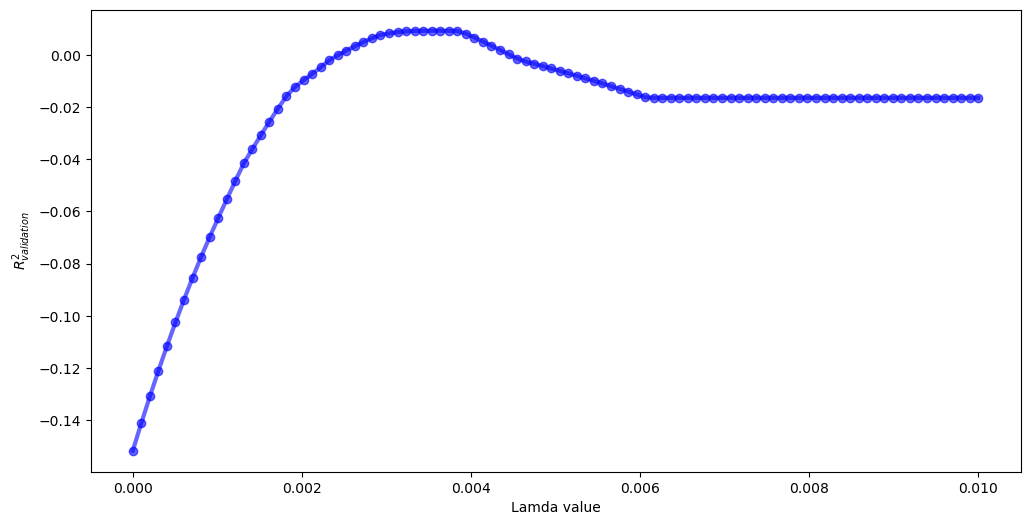

In [1308]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the size of the figure
plt.figure(figsize=(12, 6))

# Plot 
plt.plot(lambdas, valid_r2, 'bo-', color="blue", alpha=0.6, linewidth=3)

# Specify the x-axis and y-axis
plt.xlabel('Lamda value'); plt.ylabel('$R_{validation}^2$')

In [1309]:
# It is worthwhile to note the following:

# The optimal lambda is around []

In [1310]:
# Let us try to extract this optimal  𝜆

In [1311]:
# First, create a dataframe with lambdas and R2
validData_r2_lambda = pd.DataFrame({'lambdas':lambdas, 'r2':valid_r2})

# Next, sort this dataframe by R2 and find the optimal lambda
lambda_best = validData_r2_lambda.sort_values('r2', ascending = False, kind="quicksort").iloc[0,0]

# Print the optimal value of lambda
lambda_best

0.0036363636363636364

In [1312]:
# Using the tuned parameter to make predictions

In [1313]:
# Let us use the optimal lambda from the previous section with the LASSO model

In [1314]:
# Specify the model with the optimal value for lambda
lasso_reg = Lasso(alpha=lambda_best)

# Fit the lasso model with the specified lambda
lasso_reg.fit(trainData_x_num, trainData_y)

Lasso(alpha=0.0036363636363636364)

In [1315]:
# Let us take a look at the co-efficients
lasso_reg.coef_

array([ 0.        ,  0.        , -0.        , -0.00243665,  0.00022278,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.00090805,  0.        ])

In [1316]:

# Let us make the above display more informative by combining the coefficient names with their values

In [1317]:
# First, extract the names of features. Refer to lab session #1 for more pointers
featuresNames = data.columns[2:]

# Combine the variable name and estimates into a single dataframe
coeff_values = pd.DataFrame({'feature':featuresNames,'estimate':lasso_reg.coef_})

# Retain those variables whose estimates is non-zero
coeff_values_nonzero = coeff_values[(coeff_values['estimate'] != 0)]

pd.set_option('display.max_rows', 100)
coeff_values_nonzero

,feature,estimate
3,lag2w,-0.002437
4,lag3w,0.000223
12,lag9m,0.000908


In [1318]:
# Portfolio analysis using LASSO-predictions

In [1319]:
# We will repeat the procedure we used for linear regression

# First, let us make predictions for the test data using the tuned-LASSO model



In [1320]:
# Create predictions for the test data using the optimal lambda
testData_y_pred_las = lasso_reg.predict(testData_x_num)

In [1321]:
# Next, let us create a dataframe with the predicted values (for the test data)

In [1322]:
# Create a new data frame with predicted values (for the test data)
testData_y_pred_las_df = pd.DataFrame(testData_y_pred_las, columns=['dret_pred'])

In [1323]:
# Append identifying information such as date from the original test data set

In [1324]:
# Include identifying information such as date from the original training data set (trainData_x)
testData_y_pred_las_df.insert(0, 'Date', testData_x['Date']) 

In [1325]:
# Finally, add the actual return from the original dataset (testData_y)

In [1326]:
# Add the actual return
testData_y_pred_las_df.insert(2, 'dret_act', testData_y['dret'])

# Display the data frame
testData_y_pred_las_df

,Date,dret_pred,dret_act
0,2024-08-01,-0.002336,-0.065541
1,2024-08-02,0.003426,-0.042378
2,2024-08-05,-0.003125,-0.042327
3,2024-08-06,0.003160,0.008850
4,2024-08-07,0.008725,-0.044258
5,2024-08-08,-0.001692,0.036921
6,2024-08-09,0.000058,0.005834
7,2024-08-12,-0.003912,-0.012550
8,2024-08-13,0.001083,0.052357
9,2024-08-14,-0.003475,-0.031035


In [1327]:
# We are now ready to study the portfolio performance

# As before, let us define a new variable called position that takes a value of 1 or -1, depending on whether the intended position is long or short

In [1328]:
# Create a new variable called 'position' that takes a value of 1 if the intended position is long, -1 otherwise
# Reference: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
testData_y_pred_las_df['position'] = np.where(testData_y_pred_las_df['dret_pred']>0, 1, -1)
testData_y_pred_las_df

,Date,dret_pred,dret_act,position
0,2024-08-01,-0.002336,-0.065541,-1
1,2024-08-02,0.003426,-0.042378,1
2,2024-08-05,-0.003125,-0.042327,-1
3,2024-08-06,0.003160,0.008850,1
4,2024-08-07,0.008725,-0.044258,1
5,2024-08-08,-0.001692,0.036921,-1
6,2024-08-09,0.000058,0.005834,1
7,2024-08-12,-0.003912,-0.012550,-1
8,2024-08-13,0.001083,0.052357,1
9,2024-08-14,-0.003475,-0.031035,-1


In [1329]:
# Let us store the number of unique dates in a variable (useful for looping)

In [1330]:
# Store the number of unique dates in a variable
testData_count = len(testData_y_pred_las_df)
testData_count

85

In [1331]:
# Next, we are going to declare arrays for storing cumulative wealth and date indices

In [1332]:
# Declare arrays to hold the cumulative wealth

# Define an array to store cumulative wealth
cum_wealth_las = np.zeros(testData_count+1) #Returns a new array with the specified dimension

# Declare initial value to (without loss of generality) $100
cum_wealth_las[0]=100

In [1333]:
# Second, store date indices
date_idx = np.zeros(testData_count+1, dtype=int) 
date_idx[0]=0

In [1334]:
pd.set_option('display.max_rows',500)


testData_y_pred_reg_df

,Date,dret_pred,dret_act,position
0,2024-08-01,0.011594,-0.065541,1
1,2024-08-02,0.007886,-0.042378,1
2,2024-08-05,0.000911,-0.042327,1
3,2024-08-06,0.008213,0.008850,1
4,2024-08-07,0.023769,-0.044258,1
5,2024-08-08,-0.006960,0.036921,-1
6,2024-08-09,-0.000527,0.005834,-1
7,2024-08-12,-0.013783,-0.012550,-1
8,2024-08-13,0.013298,0.052357,1
9,2024-08-14,0.014250,-0.031035,1


In [1335]:

# The below code holds the core of the logic

In [1336]:
# https://www.dataquest.io/blog/tutorial-advanced-for-loops-python-pandas/
index = 1
for label, row in testData_y_pred_las_df.iterrows():
    ret = row['position'] * row['dret_act']    
    cum_wealth_las[index] = cum_wealth_las[index-1] * (1+ret)
    date_idx[index] = index
    print(f"Return for {row['Date']!r} and index {index} is {ret}. Cumulative wealth is {cum_wealth_las[index]} \n\n")
    index = index + 1

Return for Timestamp('2024-08-01 00:00:00') and index 1 is 0.06554059651757449. Cumulative wealth is 106.55405965175744 


Return for Timestamp('2024-08-02 00:00:00') and index 2 is -0.042377581921705376. Cumulative wealth is 102.03855625977481 


Return for Timestamp('2024-08-05 00:00:00') and index 3 is 0.04232673647438423. Cumulative wealth is 106.35751534080893 


Return for Timestamp('2024-08-06 00:00:00') and index 4 is 0.008849529684359148. Cumulative wealth is 107.2987293299721 


Return for Timestamp('2024-08-07 00:00:00') and index 5 is -0.044258397676563366. Cumulative wealth is 102.54985949709626 


Return for Timestamp('2024-08-08 00:00:00') and index 6 is -0.036921162045623124. Cumulative wealth is 98.76359951684809 


Return for Timestamp('2024-08-09 00:00:00') and index 7 is 0.005833854775063374. Cumulative wealth is 99.3397720134919 


Return for Timestamp('2024-08-12 00:00:00') and index 8 is 0.012549972534179665. Cumulative wealth is 100.5864834238129 


Return for T

In [1337]:
# Next, let us compare the performance of both the models over time

# Let us create a dataframe with the required information

In [1338]:
# Combine the cumulative wealth of both models into a single dataframe
cum_wealth_df = pd.DataFrame({'Day Index':date_idx, 'Regression':cum_wealth_reg,'Lasso':cum_wealth_las})
cum_wealth_df

,Day Index,Regression,Lasso
0,0,100.000000,100.000000
1,1,93.445940,106.554060
2,2,89.485927,102.038556
3,3,85.698280,106.357515
4,4,86.456670,107.298729
5,5,82.630236,102.549859
6,6,79.579432,98.763600
7,7,79.115177,99.339772
8,8,80.108070,100.586483
9,9,84.302293,105.852896


In [1339]:
# Let us graph the two series using matplotlib
# Note for graphing, we don't need the dataframe. It is more for side-by-side comparison

C:\Users\ladga\AppData\Local\Temp\ipykernel_40356\2462799538.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(date_idx, cum_wealth_reg, 'bo-', color="blue", alpha=0.6, linewidth=3, label="OLS")
C:\Users\ladga\AppData\Local\Temp\ipykernel_40356\2462799538.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(date_idx, cum_wealth_las, 'bo-', color="red", alpha=0.6, linewidth=3, label="LASSO")


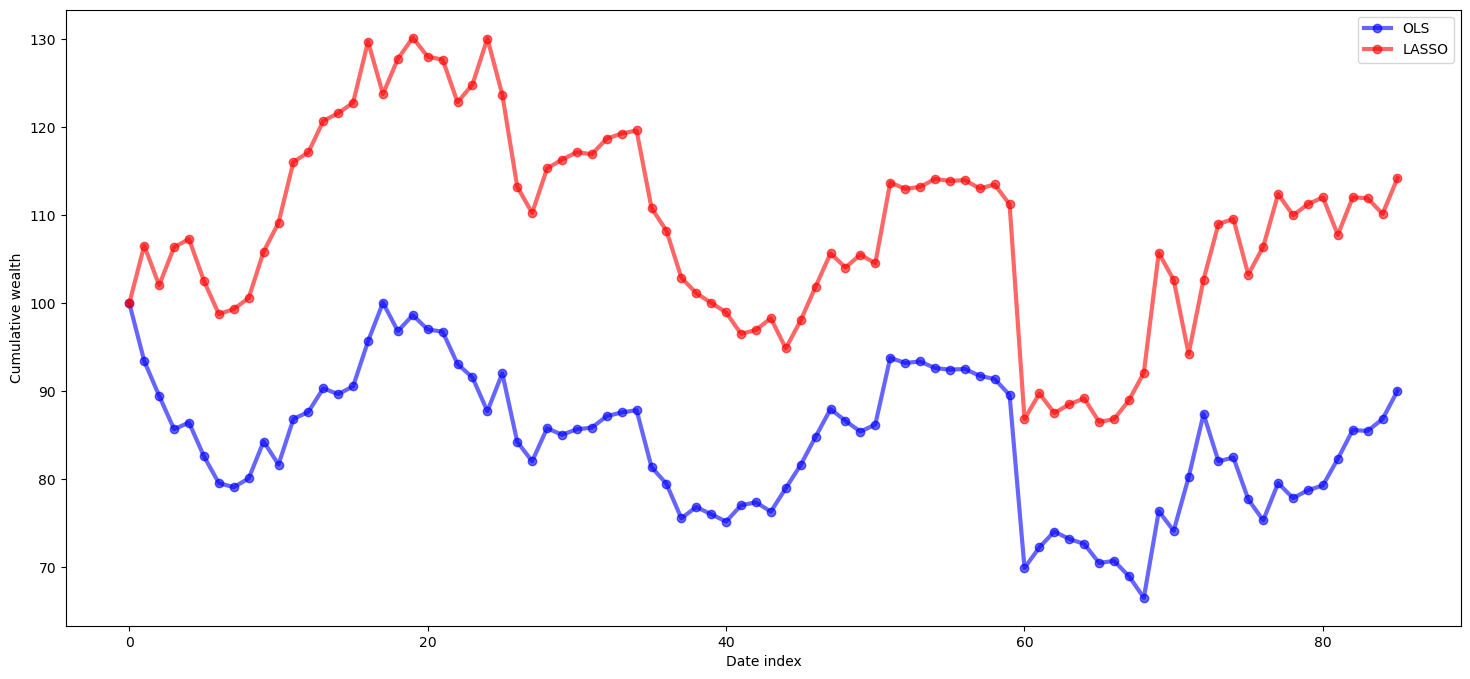

In [1340]:
# Adjust the figure size
plt.figure(figsize=(18, 8))

# Plot cumulative wealth for linear regression
plt.plot(date_idx, cum_wealth_reg, 'bo-', color="blue", alpha=0.6, linewidth=3, label="OLS")

# Plot cumulative wealth for LASSO
plt.plot(date_idx, cum_wealth_las, 'bo-', color="red", alpha=0.6, linewidth=3, label="LASSO")

# Specify the x-axis and y-axis
plt.xlabel('Date index'); plt.ylabel('Cumulative wealth')

# Show legend
plt.legend(loc="best")